## Assignment 2

This is an assignment that has the goal of familiarizing you with Web APIs, and give you more practice in writing and reading from an SQL database.

You are asked to replicate the work that we have done in class for the Citibike Web API, but for a different web source. 

Your deliverable will be: An iPython notebook with the code, and with some text explaining the data source and your objective 

Identify a web API that returns data. Preferably, you want the API to return data that change over time. Even better, select a data source for which historic data are not readily and easily accessible.
Some example options: NY Times Top Stories, News API data, Twitter trending topics

Create a database and the corresponding set of tables for storing the data, following the paradigm of the Citibike example. You should model the database properly to allow for storing of the data that are changing over time. Our approach with the Citibike database where we used two tables should provide guidance for that.

Write Python code that connects to the API, fetches the data, and stores the data in the database. Make sure that your script can run multiple times without causing errors. Write code that queries the database, fetches the data into a Pandas Dataframe, and generate some visualization of the results.

#### Preparation

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [2]:
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])
plt.rcParams['figure.figsize'] = (10, 5)

In [3]:
from sqlalchemy import create_engine

conn_string = 'mysql://{user}:{password}@{host}/'.format(
    host = '127.0.0.1', 
    user = 'root',
    password = 'dwdstudent2015')

engine = create_engine(conn_string)
con = engine.connect()

In [4]:
import requests

#### The AirVisual API
[Documentation](https://documenter.getpostman.com/view/507654/airvisual-api/2Fvvgg)
* Stations around the world have different update cycles
* Stations are hourly updated
* AQI is based on US EPA standard
* Sometimes CO is reported in µg/m3 and sometimes in ppm. However, PM2.5 and PM10 are always reported in µg/m3.  
  
* Temperature in Celsius
* Atmospheric pressure in hPa
* Humidity in %
* Wind speed in m/s, Wind direction is 0 for North

### Create a database and relevant tables

In [5]:
# Get some general idea of a city
url = 'http://api.airvisual.com/v2/city?city=New%20York&state=New%20York&country=USA&key=kYSmPHWtYyCJG7JrX'
example = requests.get(url).json()
example['data']

{'city': 'New York',
 'country': 'USA',
 'current': {'pollution': {'aqicn': 1,
   'aqius': 4,
   'maincn': 'p2',
   'mainus': 'p2',
   'ts': '2018-03-13T01:00:00.000Z'},
  'weather': {'hu': 52,
   'ic': '13n',
   'pr': 1009,
   'tp': 4,
   'ts': '2018-03-13T01:00:00.000Z',
   'wd': 90,
   'ws': 5}},
 'location': {'coordinates': [-73.928596, 40.694401], 'type': 'Point'},
 'state': 'New York'}

In [28]:
# Create a database
engine.execute("CREATE DATABASE IF NOT EXISTS air")

In [29]:
pd.read_sql("SHOW DATABASES", con = engine)

,Database
0,information_schema
1,air
2,citibike
3,college_scorecard
4,facebook
5,imdb
6,mysql
7,nyc_restaurant_inspections
8,performance_schema
9,slack


In [30]:
engine.execute("USE air")

In [31]:
# Create a table for some basic info of the cities (time-invariant)
# Give an id to each city and use it as the primary key, considering cities that share the same name
create_table_query = '''
CREATE TABLE IF NOT EXISTS City (
    id INT AUTO_INCREMENT PRIMARY KEY,
    city VARCHAR(60),
    state VARCHAR(60),
    country VARCHAR(60)
)'''

engine.execute(create_table_query)

In [32]:
pd.read_sql("DESCRIBE City", con = engine)

,Field,Type,Null,Key,Default,Extra
0,id,int(11),NO,PRI,None,auto_increment
1,city,varchar(60),YES,,None,
2,state,varchar(60),YES,,None,
3,country,varchar(60),YES,,None,


In [33]:
example['data']['current']['pollution']

{'aqicn': 1,
 'aqius': 4,
 'maincn': 'p2',
 'mainus': 'p2',
 'ts': '2018-03-13T01:00:00.000Z'}

In [62]:
# Create a table for pollution measures
# Time-variant
create_table_query = '''
CREATE TABLE IF NOT EXISTS Pollution (
    id INT,
    aqi INT,
    mainpollutant VARCHAR(20),
    time VARCHAR(200),
    PRIMARY KEY(id),
    FOREIGN KEY(id) REFERENCES City(id)
)'''

engine.execute(create_table_query)

In [63]:
pd.read_sql("DESCRIBE Pollution", con = engine)

,Field,Type,Null,Key,Default,Extra
0,id,int(11),NO,PRI,None,
1,aqi,int(11),YES,,None,
2,mainpollutant,varchar(20),YES,,None,
3,time,varchar(200),YES,,None,


In [36]:
example['data']['current']['weather']

{'hu': 52,
 'ic': '13n',
 'pr': 1009,
 'tp': 4,
 'ts': '2018-03-13T01:00:00.000Z',
 'wd': 90,
 'ws': 5}

In [98]:
# Create a table for anything related to weather
# Time-variant
create_table_query = '''
CREATE TABLE IF NOT EXISTS Weather (
    id INT,
    humidity INT,
    pressure INT,
    temperature INT,
    winddirection INT,
    windspeed INT,
    time VARCHAR(200),
    PRIMARY KEY(id),
    FOREIGN KEY(id) REFERENCES City(id)
)'''

engine.execute(create_table_query)

In [99]:
pd.read_sql("DESCRIBE Weather", con = engine)

,Field,Type,Null,Key,Default,Extra
0,id,int(11),NO,PRI,None,
1,humidity,int(11),YES,,None,
2,pressure,int(11),YES,,None,
3,temperature,int(11),YES,,None,
4,winddirection,int(11),YES,,None,
5,windspeed,int(11),YES,,None,
6,time,varchar(200),YES,,None,


### Fetch and insert data

Only cities in New York State are included in this assignment. 

In [39]:
url = 'http://api.airvisual.com/v2/cities?state=New%20York&country=USA&key=kYSmPHWtYyCJG7JrX'
nystate = requests.get(url).json()
nystate

{'data': [{'city': 'Addison'},
  {'city': 'Albany'},
  {'city': 'Buffalo'},
  {'city': 'Carmel'},
  {'city': 'Dunkirk'},
  {'city': 'East Syracuse'},
  {'city': 'Farmingdale'},
  {'city': 'Holtsville'},
  {'city': 'Ithaca'},
  {'city': 'La Fargeville'},
  {'city': 'Malone'},
  {'city': 'Middleport'},
  {'city': 'Millbrook'},
  {'city': 'Montgomery'},
  {'city': 'New York'},
  {'city': 'Newburgh'},
  {'city': 'Newcomb'},
  {'city': 'Old Forge'},
  {'city': 'Piseco'},
  {'city': 'Pomona'},
  {'city': 'Ps 314'},
  {'city': 'Riverhead'},
  {'city': 'Rochester'},
  {'city': 'Stillwater'},
  {'city': 'Tonawanda'},
  {'city': 'Utica'},
  {'city': 'White Plains'},
  {'city': 'Williamson'},
  {'city': 'Williston'},
  {'city': 'Wilmington'}],
 'status': 'success'}

In [40]:
nycities = []
for entry in nystate['data']:
    name = entry['city']
    if " " in name:
        name = name.replace(" ", "%20")
    nycities.append(name)
print(nycities)
print(len(nycities))

['Addison', 'Albany', 'Buffalo', 'Carmel', 'Dunkirk', 'East%20Syracuse', 'Farmingdale', 'Holtsville', 'Ithaca', 'La%20Fargeville', 'Malone', 'Middleport', 'Millbrook', 'Montgomery', 'New%20York', 'Newburgh', 'Newcomb', 'Old%20Forge', 'Piseco', 'Pomona', 'Ps%20314', 'Riverhead', 'Rochester', 'Stillwater', 'Tonawanda', 'Utica', 'White%20Plains', 'Williamson', 'Williston', 'Wilmington']
30


In [41]:
urls = []
for city in nycities:
    url = 'http://api.airvisual.com/v2/city?city={cityname}&state=New%20York&country=USA&key=kYSmPHWtYyCJG7JrX'.format(cityname=city)
    urls.append(url)
print(urls)    

['http://api.airvisual.com/v2/city?city=Addison&state=New%20York&country=USA&key=kYSmPHWtYyCJG7JrX', 'http://api.airvisual.com/v2/city?city=Albany&state=New%20York&country=USA&key=kYSmPHWtYyCJG7JrX', 'http://api.airvisual.com/v2/city?city=Buffalo&state=New%20York&country=USA&key=kYSmPHWtYyCJG7JrX', 'http://api.airvisual.com/v2/city?city=Carmel&state=New%20York&country=USA&key=kYSmPHWtYyCJG7JrX', 'http://api.airvisual.com/v2/city?city=Dunkirk&state=New%20York&country=USA&key=kYSmPHWtYyCJG7JrX', 'http://api.airvisual.com/v2/city?city=East%20Syracuse&state=New%20York&country=USA&key=kYSmPHWtYyCJG7JrX', 'http://api.airvisual.com/v2/city?city=Farmingdale&state=New%20York&country=USA&key=kYSmPHWtYyCJG7JrX', 'http://api.airvisual.com/v2/city?city=Holtsville&state=New%20York&country=USA&key=kYSmPHWtYyCJG7JrX', 'http://api.airvisual.com/v2/city?city=Ithaca&state=New%20York&country=USA&key=kYSmPHWtYyCJG7JrX', 'http://api.airvisual.com/v2/city?city=La%20Fargeville&state=New%20York&country=USA&key

In [42]:
# It seems like something strange will happen if call many links at almost the same time 
insert_query_template = '''INSERT IGNORE INTO City( 
    city,
    state,
    country)
    VALUES (%s, %s, %s)'''

for url in urls[0:5]:
    info = requests.get(url).json()
    insert_query_parameters = (
        info['data'].get('city'),
        info['data'].get('state'),
        info['data'].get('country')
    )
    engine.execute(insert_query_template, insert_query_parameters)

In [45]:
for url in urls[5:10]:
    info = requests.get(url).json()
    insert_query_parameters = (
        info['data'].get('city'),
        info['data'].get('state'),
        info['data'].get('country')
    )
    engine.execute(insert_query_template, insert_query_parameters)

In [47]:
for url in urls[10:15]:
    info = requests.get(url).json()
    insert_query_parameters = (
        info['data'].get('city'),
        info['data'].get('state'),
        info['data'].get('country'),
    )
    engine.execute(insert_query_template, insert_query_parameters)

In [50]:
for url in urls[15:20]:
    info = requests.get(url).json()
    insert_query_parameters = (
        info['data'].get('city'),
        info['data'].get('state'),
        info['data'].get('country'),
    )
    engine.execute(insert_query_template, insert_query_parameters)

In [52]:
for url in urls[20:25]:
    info = requests.get(url).json()
    insert_query_parameters = (
        info['data'].get('city'),
        info['data'].get('state'),
        info['data'].get('country'),
    )
    engine.execute(insert_query_template, insert_query_parameters)

In [54]:
for url in urls[25:30]:
    info = requests.get(url).json()
    insert_query_parameters = (
        info['data'].get('city'),
        info['data'].get('state'),
        info['data'].get('country'),
    )
    engine.execute(insert_query_template, insert_query_parameters)

In [55]:
pd.read_sql("SELECT * FROM City", con = engine)

,id,city,state,country
0,1,Addison,New York,USA
1,2,Albany,New York,USA
2,3,Buffalo,New York,USA
3,4,Carmel,New York,USA
4,5,Dunkirk,New York,USA
5,6,East Syracuse,New York,USA
6,7,Farmingdale,New York,USA
7,8,Holtsville,New York,USA
8,9,Ithaca,New York,USA
9,10,La Fargeville,New York,USA


In [64]:
insert_query_template = '''INSERT IGNORE INTO Pollution (
    id,
    aqi,
    mainpollutant,
    time)
    VALUES (%s, %s, %s, %s)'''

for i in range(5):
    info = requests.get(urls[i]).json()
    insert_query_parameters = (
        i+1,
        info['data']['current']['pollution']['aqius'],
        info['data']['current']['pollution']['mainus'],
        info['data']['current']['pollution']['ts']
    )
    engine.execute(insert_query_template, insert_query_parameters)

In [69]:
for i in range(5,10):
    info = requests.get(urls[i]).json()
    insert_query_parameters = (
        i+1,
        info['data']['current']['pollution']['aqius'],
        info['data']['current']['pollution']['mainus'],
        info['data']['current']['pollution']['ts']
    )
    engine.execute(insert_query_template, insert_query_parameters)

In [73]:
for i in range(10,15):
    info = requests.get(urls[i]).json()
    insert_query_parameters = (
        i+1,
        info['data']['current']['pollution']['aqius'],
        info['data']['current']['pollution']['mainus'],
        info['data']['current']['pollution']['ts']
    )
    engine.execute(insert_query_template, insert_query_parameters)

In [75]:
for i in range(15,20):
    info = requests.get(urls[i]).json()
    insert_query_parameters = (
        i+1,
        info['data']['current']['pollution']['aqius'],
        info['data']['current']['pollution']['mainus'],
        info['data']['current']['pollution']['ts']
    )
    engine.execute(insert_query_template, insert_query_parameters)

In [77]:
for i in range(20,25):
    info = requests.get(urls[i]).json()
    insert_query_parameters = (
        i+1,
        info['data']['current']['pollution']['aqius'],
        info['data']['current']['pollution']['mainus'],
        info['data']['current']['pollution']['ts']
    )
    engine.execute(insert_query_template, insert_query_parameters)

In [81]:
for i in range(25,30):
    info = requests.get(urls[i]).json()
    insert_query_parameters = (
        i+1,
        info['data']['current']['pollution']['aqius'],
        info['data']['current']['pollution']['mainus'],
        info['data']['current']['pollution']['ts']
    )
    engine.execute(insert_query_template, insert_query_parameters)

In [82]:
pd.read_sql("SELECT * FROM Pollution", con = engine)

,id,aqi,mainpollutant,time
0,1,31,o3,2018-03-13T01:00:00.000Z
1,2,32,o3,2018-03-13T01:00:00.000Z
2,3,30,p2,2018-03-13T01:00:00.000Z
3,4,32,o3,2018-03-13T01:00:00.000Z
4,5,35,o3,2018-03-13T01:00:00.000Z
5,6,34,o3,2018-03-13T00:00:00.000Z
6,7,32,o3,2018-03-13T01:00:00.000Z
7,8,31,o3,2018-03-12T23:00:00.000Z
8,9,34,o3,2018-03-13T01:00:00.000Z
9,10,31,o3,2018-03-13T01:00:00.000Z


In [100]:
insert_query_template = '''INSERT IGNORE INTO Weather (
    id,
    humidity,
    pressure,
    temperature,
    winddirection,
    windspeed,
    time)
    VALUES (%s, %s, %s, %s, %s, %s, %s)'''

for i in range(5):
    info = requests.get(urls[i]).json()
    insert_query_parameters = (
        i+1,
        info['data']['current']['weather']['hu'],
        info['data']['current']['weather']['pr'],
        info['data']['current']['weather']['tp'],
        info['data']['current']['weather']['wd'],
        info['data']['current']['weather']['ws'],
        info['data']['current']['weather']['ts']
    )
    engine.execute(insert_query_template, insert_query_parameters)

In [102]:
for i in range(5,10):
    info = requests.get(urls[i]).json()
    insert_query_parameters = (
        i+1,
        info['data']['current']['weather']['hu'],
        info['data']['current']['weather']['pr'],
        info['data']['current']['weather']['tp'],
        info['data']['current']['weather']['wd'],
        info['data']['current']['weather']['ws'],
        info['data']['current']['weather']['ts']
    )
    engine.execute(insert_query_template, insert_query_parameters)

In [105]:
for i in range(10,15):
    info = requests.get(urls[i]).json()
    insert_query_parameters = (
        i+1,
        info['data']['current']['weather']['hu'],
        info['data']['current']['weather']['pr'],
        info['data']['current']['weather']['tp'],
        info['data']['current']['weather']['wd'],
        info['data']['current']['weather']['ws'],
        info['data']['current']['weather']['ts']
    )
    engine.execute(insert_query_template, insert_query_parameters)

/usr/local/lib/python3.5/dist-packages/sqlalchemy/engine/default.py:507: Warning: (1062, "Duplicate entry '11' for key 'PRIMARY'")
  cursor.execute(statement, parameters)
/usr/local/lib/python3.5/dist-packages/sqlalchemy/engine/default.py:507: Warning: (1062, "Duplicate entry '12' for key 'PRIMARY'")
  cursor.execute(statement, parameters)


In [107]:
for i in range(15,20):
    info = requests.get(urls[i]).json()
    insert_query_parameters = (
        i+1,
        info['data']['current']['weather']['hu'],
        info['data']['current']['weather']['pr'],
        info['data']['current']['weather']['tp'],
        info['data']['current']['weather']['wd'],
        info['data']['current']['weather']['ws'],
        info['data']['current']['weather']['ts']
    )
    engine.execute(insert_query_template, insert_query_parameters)

In [112]:
for i in range(20,25):
    info = requests.get(urls[i]).json()
    insert_query_parameters = (
        i+1,
        info['data']['current']['weather']['hu'],
        info['data']['current']['weather']['pr'],
        info['data']['current']['weather']['tp'],
        info['data']['current']['weather']['wd'],
        info['data']['current']['weather']['ws'],
        info['data']['current']['weather']['ts']
    )
    engine.execute(insert_query_template, insert_query_parameters)

In [114]:
for i in range(25,30):
    info = requests.get(urls[i]).json()
    insert_query_parameters = (
        i+1,
        info['data']['current']['weather']['hu'],
        info['data']['current']['weather']['pr'],
        info['data']['current']['weather']['tp'],
        info['data']['current']['weather']['wd'],
        info['data']['current']['weather']['ws'],
        info['data']['current']['weather']['ts']
    )
    engine.execute(insert_query_template, insert_query_parameters)

In [115]:
pd.read_sql("SELECT * FROM Weather", con = engine)

,id,humidity,pressure,temperature,winddirection,windspeed,time
0,1,86,1012,-1,40,3,2018-03-13T01:00:00.000Z
1,2,51,1013,2,60,1,2018-03-13T01:00:00.000Z
2,3,74,1014,-1,50,1,2018-03-13T01:00:00.000Z
3,4,64,1011,3,60,2,2018-03-13T01:00:00.000Z
4,5,86,1014,-2,320,2,2018-03-13T01:00:00.000Z
5,6,100,1013,0,153,0,2018-03-13T00:00:00.000Z
6,7,98,1011,4,90,6,2018-03-13T01:00:00.000Z
7,8,98,1011,4,90,6,2018-03-13T01:00:00.000Z
8,9,92,1012,-1,50,2,2018-03-13T01:00:00.000Z
9,10,92,1013,0,110,2,2018-03-13T01:00:00.000Z


### Some interesting findings

In [132]:
# Air Quality Index the smaller the better
# Air quality are good for all cities (aqi below 50)
# New York City is the busiest with a great amount of cars but the air quality is the best
query1 = '''
SELECT C.city, P.aqi
FROM City C JOIN Pollution P
ON C.id = P.id
ORDER BY P.aqi
'''
q1 = pd.read_sql(query1, con = engine)
q1 = q1.set_index('city')
q1

,aqi
city,
New York,4
Ps 314,10
Williston,11
Rochester,12
Utica,14
Newburgh,21
Buffalo,30
Holtsville,31
Addison,31


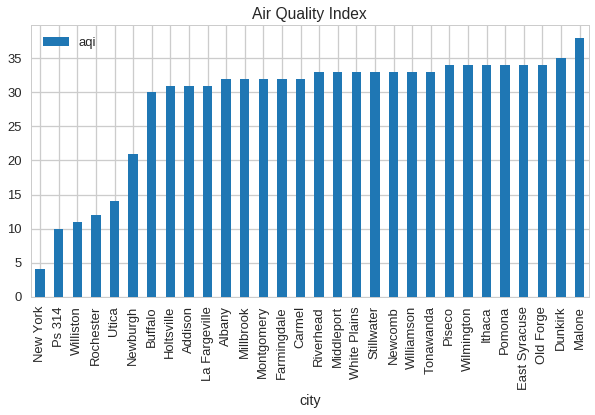

In [135]:
# Most cities have index between 30 and 35 
q1.plot(kind = 'bar', title ="Air Quality Index")

In [147]:
# Major pollutant of New York State are O3 and pm2.5
# About twice as many cities suffering from Ozone O3 as cities suffering from pm2.5
query2 = '''
SELECT mainpollutant, COUNT(*) AS number_of_cities
FROM Pollution
GROUP BY mainpollutant
'''
q2 = pd.read_sql(query2, con = engine)
q2 = q2.set_index('mainpollutant')
q2

,number_of_cities
mainpollutant,
o3,21
p2,9


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0bf8184e48>],
      dtype=object)

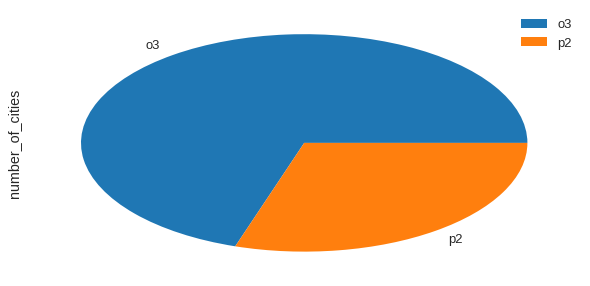

In [148]:
q2.plot(kind = 'pie', subplots = True)

In [150]:
query3 = '''
SELECT AVG(humidity), AVG(pressure), MAX(temperature), MIN(temperature)
FROM Weather
'''
q3 = pd.read_sql(query3, con = engine)
q3

,AVG(humidity),AVG(pressure),MAX(temperature),MIN(temperature)
0,74.4,1010.7667,4,-2


In [153]:
# N60° is the most common wind direction
query4 = '''
SELECT winddirection, COUNT(winddirection) AS cnt
FROM Weather
GROUP BY winddirection
ORDER BY cnt DESC
'''
q4 = pd.read_sql(query4, con = engine)
q4

,winddirection,cnt
0,60,9
1,50,4
2,90,4
3,70,3
4,320,2
5,40,1
6,153,1
7,110,1
8,128,1
9,73,1
